In [ ]:
# 保存生成器和判别器的權重
#generator.save_weights('generator_weights.h5')
#discriminator.save_weights('discriminator_weights.h5')

# 灰度轉換

In [4]:
# pip install opencv-python
# pip install opencv-python --upgrade

import cv2
import os

# 指定原始彩色圖像文件夾和目標灰度圖像文件夾
# original_folder = r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\2022-3-8'
# gray_folder = r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\2022-3-8\gray\class_1'
original_folder = r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\number'
gray_folder = r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\number\gray\class_1'

# 確保目標文件夾存在
if not os.path.exists(gray_folder):
    os.makedirs(gray_folder)

# 遍歷原始文件夾中的每個圖像
for filename in os.listdir(original_folder):
    if (filename.endswith('.JPG') or filename.endswith('.jpg')):
        # 讀取原始圖像
        original_image_path = os.path.join(original_folder, filename)
        original_image = cv2.imread(original_image_path)

        # 將彩色圖像轉換為灰度圖像
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        # 保存灰度圖像到目標文件夾
        gray_image_path = os.path.join(gray_folder, filename)
        cv2.imwrite(gray_image_path, gray_image)

print("灰度轉換完成")


灰度轉換完成


# 訓練模型

In [38]:
# pip install --upgrade protobuf
# pip install protobuf==3.20.0

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

'''
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    # 在生成器的最後一層使用 tanh
    model.add(Conv2D(1, (7, 7), activation='tanh', padding='same'))
    return model
'''

def build_generator(latent_dim):
    
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='tanh', padding='same'))
    return model
    


'''
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model
'''

def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))  # 添加 Dropout 防止過擬合
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


latent_dim = 100
input_shape = (28, 28, 1)


discriminator = build_discriminator(input_shape)
#discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = build_generator(latent_dim)
#generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

discriminator.trainable = False
gan = build_gan(generator, discriminator)
#gan.compile(loss='binary_crossentropy', optimizer='adam')


# 修改原來的 optimizer='adam' 為
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# 定义图像数据生成器
datagen = ImageDataGenerator(rescale=1./255)

# 通过图像数据生成器加载训练数据
batch_size = 16
train_generator = datagen.flow_from_directory(
    r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\number\gray',  
    target_size=(28, 28),     
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)


epochs = 20000  # 你可以根据需要设置训练的轮数
# 训练GAN模型
print("訓練開始!")
for epoch in range(epochs):
    # 生成潜在噪声
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    # 使用生成器生成假影像
    generated_images = generator.predict(noise)

    # 从数据生成器中获取一批真实影像
    real_images, labels_real = train_generator.next()
    
    # print(generated_images)

    # 进行判别器和生成器的训练
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    labels_fake = np.zeros((batch_size, 1))  # 添加缺失的 labels_fake
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    # 修改生成器的輸出形狀
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)
    labels_fake = np.zeros((batch_size, 1))  # 添加缺失的 labels_fake

    # 重新進行判别器和生成器的訓練
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, labels_gan)
    

print("訓練完成!")

Found 146 images belonging to 1 classes.
訓練開始!
訓練完成!


# 顯示假的影像

<ipython-input-41-e576bf6fdfaf>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


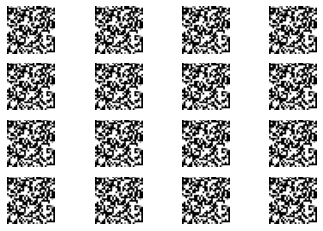

In [41]:
import matplotlib.pyplot as plt

# 生成潛在噪聲
noise = np.random.normal(0, 1, (batch_size, latent_dim))

# 使用生成器生成假影像
generated_images = generator.predict(noise)

# 將生成的假影像顯示出來
rows, columns = 4, 4 # 設定顯示的行列數
fig, axs = plt.subplots(rows, columns)

# 將每個生成的影像放入子圖
for i in range(rows):
    for j in range(columns):
        axs[i, j].imshow(generated_images[i * columns + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')

plt.show()


# 能用的

In [1]:
import os
import numpy as np
import cv2  # 需要安裝 OpenCV: pip install opencv-python
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, PReLU
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import winsound

plt.switch_backend('agg')


class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=50, height=50, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)
        
        self.optimizer = Adam(lr=0.0002, beta_1=0.6, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(PReLU()) #LeakyReLU(alpha=0.2)
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(PReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(PReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(PReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(4096))
        model.add(PReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(8192))
        model.add(PReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense(8192))
        model.add(PReLU())
        model.add(Dense(4096))
        model.add(PReLU())
        model.add(Dense(2048))
        model.add(PReLU())
        model.add(Dense(1024))
        model.add(PReLU())
        model.add(Dense(512))
        model.add(PReLU())
        model.add(Dense(256))
        model.add(PReLU())
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model
    
    #epochs=20000
    def train(self, X_train, epochs=10002, batch=32, save_interval=100):
        for cnt in range(epochs):

            # train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)]

            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)

            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)


    def plot_images(self, save2file=False, samples=16, step=0):
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/dolphin_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(50, 50))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, 0]  # 取出灰階通道
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
            winsound.Beep(1000,1000)
        else:
            plt.show()



if __name__ == '__main__':
    image_folder_path = r'C:\Users\Tosha.E.T\Documents\GitHub\DolphinSkull\2022-3-8\gray\class'
    image_files = os.listdir(image_folder_path)
    X_train = []

    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and not image.size == 0:
            # 如果圖片成功讀取，並且尺寸不為空，則進行調整大小
            image = cv2.resize(image, (50, 50))
            X_train.append(image)
            #print(image)
        else:
            print(image_file)

    X_train = np.array(X_train) / 255.0
    X_train = np.expand_dims(X_train, axis=-1)

    gan = GAN()
    gan.train(X_train)
    

    
# 訓練完畢提示音    
winsound.Beep(2000,2000)

c:\users\tosha.e.t\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense_7 (Dense)             (None, 8192)              20488192  
                                                                 
 p_re_lu_6 (PReLU)           (None, 8192)              8192      
                                                                 
 dense_8 (Dense)             (None, 4096)              33558528  
                                                                 
 p_re_lu_7 (PReLU)           (None, 4096)              4096      
                                                                 
 dense_9 (Dense)             (None, 2048)              8390656   
                                                                 
 p_re_lu_8 (PReLU)           (None, 2048)             

epoch: 75, [Discriminator :: d_loss: 0.238242], [ Generator :: loss: 20.265175]
epoch: 76, [Discriminator :: d_loss: 0.058357], [ Generator :: loss: 14.102161]
epoch: 77, [Discriminator :: d_loss: 0.397834], [ Generator :: loss: 16.598852]
epoch: 78, [Discriminator :: d_loss: 0.070046], [ Generator :: loss: 14.094820]
epoch: 79, [Discriminator :: d_loss: 0.116185], [ Generator :: loss: 16.219124]
epoch: 80, [Discriminator :: d_loss: 0.038320], [ Generator :: loss: 12.907837]
epoch: 81, [Discriminator :: d_loss: 0.093465], [ Generator :: loss: 18.056252]
epoch: 82, [Discriminator :: d_loss: 0.023297], [ Generator :: loss: 16.712528]
epoch: 83, [Discriminator :: d_loss: 0.023689], [ Generator :: loss: 17.352798]
epoch: 84, [Discriminator :: d_loss: 0.020354], [ Generator :: loss: 11.902086]
epoch: 85, [Discriminator :: d_loss: 0.376357], [ Generator :: loss: 28.501148]
epoch: 86, [Discriminator :: d_loss: 2.150160], [ Generator :: loss: 10.381218]
epoch: 87, [Discriminator :: d_loss: 0.1

epoch: 177, [Discriminator :: d_loss: 0.270044], [ Generator :: loss: 6.941800]
epoch: 178, [Discriminator :: d_loss: 0.219217], [ Generator :: loss: 10.617995]
epoch: 179, [Discriminator :: d_loss: 0.106750], [ Generator :: loss: 11.575678]
epoch: 180, [Discriminator :: d_loss: 0.045685], [ Generator :: loss: 10.762592]
epoch: 181, [Discriminator :: d_loss: 0.017546], [ Generator :: loss: 11.609230]
epoch: 182, [Discriminator :: d_loss: 0.055151], [ Generator :: loss: 17.634041]
epoch: 183, [Discriminator :: d_loss: 0.005491], [ Generator :: loss: 18.989864]
epoch: 184, [Discriminator :: d_loss: 0.014221], [ Generator :: loss: 17.519363]
epoch: 185, [Discriminator :: d_loss: 0.022102], [ Generator :: loss: 17.614201]
epoch: 186, [Discriminator :: d_loss: 0.014410], [ Generator :: loss: 17.254917]
epoch: 187, [Discriminator :: d_loss: 0.002565], [ Generator :: loss: 21.361647]
epoch: 188, [Discriminator :: d_loss: 0.001374], [ Generator :: loss: 21.466795]
epoch: 189, [Discriminator ::

epoch: 279, [Discriminator :: d_loss: 0.006693], [ Generator :: loss: 12.372696]
epoch: 280, [Discriminator :: d_loss: 0.000308], [ Generator :: loss: 11.623554]
epoch: 281, [Discriminator :: d_loss: 0.002413], [ Generator :: loss: 10.106864]
epoch: 282, [Discriminator :: d_loss: 0.000814], [ Generator :: loss: 11.714708]
epoch: 283, [Discriminator :: d_loss: 0.125840], [ Generator :: loss: 20.471291]
epoch: 284, [Discriminator :: d_loss: 1.152417], [ Generator :: loss: 12.373075]
epoch: 285, [Discriminator :: d_loss: 0.007573], [ Generator :: loss: 10.633841]
epoch: 286, [Discriminator :: d_loss: 0.210726], [ Generator :: loss: 14.980618]
epoch: 287, [Discriminator :: d_loss: 0.161672], [ Generator :: loss: 19.694740]
epoch: 288, [Discriminator :: d_loss: 0.798522], [ Generator :: loss: 13.768460]
epoch: 289, [Discriminator :: d_loss: 0.028250], [ Generator :: loss: 9.514601]
epoch: 290, [Discriminator :: d_loss: 0.028093], [ Generator :: loss: 8.231271]
epoch: 291, [Discriminator :: 

epoch: 382, [Discriminator :: d_loss: 0.005043], [ Generator :: loss: 7.107428]
epoch: 383, [Discriminator :: d_loss: 0.002191], [ Generator :: loss: 6.859969]
epoch: 384, [Discriminator :: d_loss: 0.003391], [ Generator :: loss: 6.395262]
epoch: 385, [Discriminator :: d_loss: 0.007382], [ Generator :: loss: 6.916378]
epoch: 386, [Discriminator :: d_loss: 0.004905], [ Generator :: loss: 7.824976]
epoch: 387, [Discriminator :: d_loss: 0.001745], [ Generator :: loss: 7.333589]
epoch: 388, [Discriminator :: d_loss: 0.002911], [ Generator :: loss: 7.235051]
epoch: 389, [Discriminator :: d_loss: 0.013871], [ Generator :: loss: 6.666447]
epoch: 390, [Discriminator :: d_loss: 0.010986], [ Generator :: loss: 7.595897]
epoch: 391, [Discriminator :: d_loss: 0.002270], [ Generator :: loss: 7.506660]
epoch: 392, [Discriminator :: d_loss: 0.001111], [ Generator :: loss: 7.377128]
epoch: 393, [Discriminator :: d_loss: 0.001934], [ Generator :: loss: 7.846630]
epoch: 394, [Discriminator :: d_loss: 0.

epoch: 485, [Discriminator :: d_loss: 0.327032], [ Generator :: loss: 16.172543]
epoch: 486, [Discriminator :: d_loss: 0.207807], [ Generator :: loss: 11.197499]
epoch: 487, [Discriminator :: d_loss: 0.217184], [ Generator :: loss: 10.972938]
epoch: 488, [Discriminator :: d_loss: 0.190151], [ Generator :: loss: 8.339705]
epoch: 489, [Discriminator :: d_loss: 0.208860], [ Generator :: loss: 7.577465]
epoch: 490, [Discriminator :: d_loss: 0.127068], [ Generator :: loss: 8.295304]
epoch: 491, [Discriminator :: d_loss: 0.152797], [ Generator :: loss: 8.240698]
epoch: 492, [Discriminator :: d_loss: 0.079665], [ Generator :: loss: 7.341722]
epoch: 493, [Discriminator :: d_loss: 0.074014], [ Generator :: loss: 7.012683]
epoch: 494, [Discriminator :: d_loss: 0.028584], [ Generator :: loss: 7.424076]
epoch: 495, [Discriminator :: d_loss: 0.049284], [ Generator :: loss: 9.013548]
epoch: 496, [Discriminator :: d_loss: 0.007770], [ Generator :: loss: 12.089253]
epoch: 497, [Discriminator :: d_loss

epoch: 587, [Discriminator :: d_loss: 0.001158], [ Generator :: loss: 7.833396]
epoch: 588, [Discriminator :: d_loss: 0.001579], [ Generator :: loss: 7.638750]
epoch: 589, [Discriminator :: d_loss: 0.004137], [ Generator :: loss: 8.113620]
epoch: 590, [Discriminator :: d_loss: 0.000951], [ Generator :: loss: 8.129079]
epoch: 591, [Discriminator :: d_loss: 0.002024], [ Generator :: loss: 8.134953]
epoch: 592, [Discriminator :: d_loss: 0.002348], [ Generator :: loss: 7.640298]
epoch: 593, [Discriminator :: d_loss: 0.002906], [ Generator :: loss: 8.268750]
epoch: 594, [Discriminator :: d_loss: 0.001937], [ Generator :: loss: 6.919573]
epoch: 595, [Discriminator :: d_loss: 0.010703], [ Generator :: loss: 5.845933]
epoch: 596, [Discriminator :: d_loss: 5.488937], [ Generator :: loss: 48.620529]
epoch: 597, [Discriminator :: d_loss: 4.063310], [ Generator :: loss: 28.024046]
epoch: 598, [Discriminator :: d_loss: 3.149156], [ Generator :: loss: 4.523943]
epoch: 599, [Discriminator :: d_loss: 

epoch: 690, [Discriminator :: d_loss: 1.191595], [ Generator :: loss: 5.037479]
epoch: 691, [Discriminator :: d_loss: 0.395244], [ Generator :: loss: 3.218803]
epoch: 692, [Discriminator :: d_loss: 0.130405], [ Generator :: loss: 2.108048]
epoch: 693, [Discriminator :: d_loss: 0.175154], [ Generator :: loss: 2.083511]
epoch: 694, [Discriminator :: d_loss: 0.124117], [ Generator :: loss: 2.753835]
epoch: 695, [Discriminator :: d_loss: 0.067481], [ Generator :: loss: 3.535119]
epoch: 696, [Discriminator :: d_loss: 0.023599], [ Generator :: loss: 4.653578]
epoch: 697, [Discriminator :: d_loss: 0.015220], [ Generator :: loss: 4.833954]
epoch: 698, [Discriminator :: d_loss: 0.011296], [ Generator :: loss: 5.634035]
epoch: 699, [Discriminator :: d_loss: 0.005817], [ Generator :: loss: 5.695854]
epoch: 700, [Discriminator :: d_loss: 0.006610], [ Generator :: loss: 5.757483]
epoch: 701, [Discriminator :: d_loss: 0.009918], [ Generator :: loss: 5.930053]
epoch: 702, [Discriminator :: d_loss: 0.

epoch: 793, [Discriminator :: d_loss: 0.071587], [ Generator :: loss: 4.691925]
epoch: 794, [Discriminator :: d_loss: 0.030731], [ Generator :: loss: 5.226352]
epoch: 795, [Discriminator :: d_loss: 0.024880], [ Generator :: loss: 5.560809]
epoch: 796, [Discriminator :: d_loss: 0.011728], [ Generator :: loss: 5.869984]
epoch: 797, [Discriminator :: d_loss: 0.007158], [ Generator :: loss: 6.029826]
epoch: 798, [Discriminator :: d_loss: 0.006501], [ Generator :: loss: 5.949134]
epoch: 799, [Discriminator :: d_loss: 0.005858], [ Generator :: loss: 5.604731]
epoch: 800, [Discriminator :: d_loss: 0.003908], [ Generator :: loss: 5.679783]
epoch: 801, [Discriminator :: d_loss: 0.004426], [ Generator :: loss: 5.723274]
epoch: 802, [Discriminator :: d_loss: 0.003387], [ Generator :: loss: 5.637609]
epoch: 803, [Discriminator :: d_loss: 0.009549], [ Generator :: loss: 5.832412]
epoch: 804, [Discriminator :: d_loss: 0.008949], [ Generator :: loss: 6.599191]
epoch: 805, [Discriminator :: d_loss: 0.

epoch: 896, [Discriminator :: d_loss: 1.197226], [ Generator :: loss: 26.574327]
epoch: 897, [Discriminator :: d_loss: 1.357768], [ Generator :: loss: 18.226677]
epoch: 898, [Discriminator :: d_loss: 0.725846], [ Generator :: loss: 11.360725]
epoch: 899, [Discriminator :: d_loss: 0.422145], [ Generator :: loss: 5.844498]
epoch: 900, [Discriminator :: d_loss: 0.369046], [ Generator :: loss: 4.582065]
epoch: 901, [Discriminator :: d_loss: 0.269261], [ Generator :: loss: 3.834872]
epoch: 902, [Discriminator :: d_loss: 0.219516], [ Generator :: loss: 3.741052]
epoch: 903, [Discriminator :: d_loss: 0.212916], [ Generator :: loss: 3.684104]
epoch: 904, [Discriminator :: d_loss: 0.157847], [ Generator :: loss: 3.787867]
epoch: 905, [Discriminator :: d_loss: 0.113057], [ Generator :: loss: 4.208021]
epoch: 906, [Discriminator :: d_loss: 0.077102], [ Generator :: loss: 4.283162]
epoch: 907, [Discriminator :: d_loss: 0.071516], [ Generator :: loss: 4.433193]
epoch: 908, [Discriminator :: d_loss:

epoch: 999, [Discriminator :: d_loss: 0.019524], [ Generator :: loss: 10.904066]
epoch: 1000, [Discriminator :: d_loss: 0.046274], [ Generator :: loss: 8.969893]
epoch: 1001, [Discriminator :: d_loss: 0.003400], [ Generator :: loss: 8.644808]
epoch: 1002, [Discriminator :: d_loss: 0.270189], [ Generator :: loss: 13.717111]
epoch: 1003, [Discriminator :: d_loss: 0.959986], [ Generator :: loss: 7.481652]
epoch: 1004, [Discriminator :: d_loss: 0.023431], [ Generator :: loss: 8.357620]
epoch: 1005, [Discriminator :: d_loss: 0.154111], [ Generator :: loss: 13.942390]
epoch: 1006, [Discriminator :: d_loss: 0.035550], [ Generator :: loss: 17.427067]
epoch: 1007, [Discriminator :: d_loss: 0.154328], [ Generator :: loss: 16.026539]
epoch: 1008, [Discriminator :: d_loss: 0.038333], [ Generator :: loss: 16.893677]
epoch: 1009, [Discriminator :: d_loss: 0.009564], [ Generator :: loss: 13.593649]
epoch: 1010, [Discriminator :: d_loss: 0.013157], [ Generator :: loss: 12.962243]
epoch: 1011, [Discrim

epoch: 1100, [Discriminator :: d_loss: 0.320147], [ Generator :: loss: 4.051195]
epoch: 1101, [Discriminator :: d_loss: 0.295893], [ Generator :: loss: 4.109336]
epoch: 1102, [Discriminator :: d_loss: 0.282543], [ Generator :: loss: 4.023447]
epoch: 1103, [Discriminator :: d_loss: 0.273537], [ Generator :: loss: 4.328649]
epoch: 1104, [Discriminator :: d_loss: 0.267936], [ Generator :: loss: 4.482579]
epoch: 1105, [Discriminator :: d_loss: 0.261654], [ Generator :: loss: 4.229976]
epoch: 1106, [Discriminator :: d_loss: 0.248418], [ Generator :: loss: 4.801031]
epoch: 1107, [Discriminator :: d_loss: 0.245388], [ Generator :: loss: 4.328404]
epoch: 1108, [Discriminator :: d_loss: 0.226254], [ Generator :: loss: 4.032994]
epoch: 1109, [Discriminator :: d_loss: 0.197581], [ Generator :: loss: 4.499023]
epoch: 1110, [Discriminator :: d_loss: 0.165774], [ Generator :: loss: 4.546823]
epoch: 1111, [Discriminator :: d_loss: 0.130735], [ Generator :: loss: 5.038573]
epoch: 1112, [Discriminator 

epoch: 1202, [Discriminator :: d_loss: 0.114755], [ Generator :: loss: 5.059282]
epoch: 1203, [Discriminator :: d_loss: 0.112853], [ Generator :: loss: 4.677801]
epoch: 1204, [Discriminator :: d_loss: 0.081315], [ Generator :: loss: 5.054879]
epoch: 1205, [Discriminator :: d_loss: 0.060333], [ Generator :: loss: 4.773835]
epoch: 1206, [Discriminator :: d_loss: 0.076574], [ Generator :: loss: 6.029881]
epoch: 1207, [Discriminator :: d_loss: 0.037560], [ Generator :: loss: 6.087708]
epoch: 1208, [Discriminator :: d_loss: 0.050334], [ Generator :: loss: 4.681631]
epoch: 1209, [Discriminator :: d_loss: 0.072126], [ Generator :: loss: 8.092459]
epoch: 1210, [Discriminator :: d_loss: 0.052025], [ Generator :: loss: 7.980903]
epoch: 1211, [Discriminator :: d_loss: 0.040820], [ Generator :: loss: 7.615432]
epoch: 1212, [Discriminator :: d_loss: 0.043113], [ Generator :: loss: 6.338772]
epoch: 1213, [Discriminator :: d_loss: 0.020025], [ Generator :: loss: 6.316875]
epoch: 1214, [Discriminator 

epoch: 1303, [Discriminator :: d_loss: 0.045797], [ Generator :: loss: 6.475190]
epoch: 1304, [Discriminator :: d_loss: 0.024311], [ Generator :: loss: 7.033655]
epoch: 1305, [Discriminator :: d_loss: 0.024260], [ Generator :: loss: 6.782894]
epoch: 1306, [Discriminator :: d_loss: 0.012271], [ Generator :: loss: 6.399066]
epoch: 1307, [Discriminator :: d_loss: 0.014978], [ Generator :: loss: 6.199545]
epoch: 1308, [Discriminator :: d_loss: 0.016495], [ Generator :: loss: 6.033005]
epoch: 1309, [Discriminator :: d_loss: 0.015273], [ Generator :: loss: 6.838696]
epoch: 1310, [Discriminator :: d_loss: 0.009208], [ Generator :: loss: 6.799914]
epoch: 1311, [Discriminator :: d_loss: 0.012649], [ Generator :: loss: 6.485320]
epoch: 1312, [Discriminator :: d_loss: 0.008968], [ Generator :: loss: 6.355114]
epoch: 1313, [Discriminator :: d_loss: 0.010225], [ Generator :: loss: 6.980136]
epoch: 1314, [Discriminator :: d_loss: 0.007784], [ Generator :: loss: 7.307092]
epoch: 1315, [Discriminator 

epoch: 1404, [Discriminator :: d_loss: 0.138034], [ Generator :: loss: 5.877783]
epoch: 1405, [Discriminator :: d_loss: 0.111163], [ Generator :: loss: 5.671351]
epoch: 1406, [Discriminator :: d_loss: 0.085553], [ Generator :: loss: 5.301251]
epoch: 1407, [Discriminator :: d_loss: 0.079247], [ Generator :: loss: 5.460546]
epoch: 1408, [Discriminator :: d_loss: 0.054372], [ Generator :: loss: 5.526039]
epoch: 1409, [Discriminator :: d_loss: 0.050230], [ Generator :: loss: 5.657477]
epoch: 1410, [Discriminator :: d_loss: 0.033160], [ Generator :: loss: 6.011588]
epoch: 1411, [Discriminator :: d_loss: 0.017084], [ Generator :: loss: 6.318805]
epoch: 1412, [Discriminator :: d_loss: 0.024167], [ Generator :: loss: 6.422081]
epoch: 1413, [Discriminator :: d_loss: 0.021946], [ Generator :: loss: 6.184957]
epoch: 1414, [Discriminator :: d_loss: 0.020142], [ Generator :: loss: 9.209595]
epoch: 1415, [Discriminator :: d_loss: 0.018314], [ Generator :: loss: 9.518211]
epoch: 1416, [Discriminator 

epoch: 1506, [Discriminator :: d_loss: 0.073169], [ Generator :: loss: 5.657235]
epoch: 1507, [Discriminator :: d_loss: 0.043071], [ Generator :: loss: 4.172457]
epoch: 1508, [Discriminator :: d_loss: 0.053648], [ Generator :: loss: 3.967259]
epoch: 1509, [Discriminator :: d_loss: 0.031754], [ Generator :: loss: 4.182744]
epoch: 1510, [Discriminator :: d_loss: 0.025936], [ Generator :: loss: 4.308671]
epoch: 1511, [Discriminator :: d_loss: 0.018189], [ Generator :: loss: 4.354172]
epoch: 1512, [Discriminator :: d_loss: 0.014338], [ Generator :: loss: 5.206309]
epoch: 1513, [Discriminator :: d_loss: 0.016888], [ Generator :: loss: 5.410655]
epoch: 1514, [Discriminator :: d_loss: 0.011336], [ Generator :: loss: 5.702062]
epoch: 1515, [Discriminator :: d_loss: 0.005682], [ Generator :: loss: 5.774992]
epoch: 1516, [Discriminator :: d_loss: 0.006676], [ Generator :: loss: 5.822599]
epoch: 1517, [Discriminator :: d_loss: 0.007424], [ Generator :: loss: 5.711652]
epoch: 1518, [Discriminator 

epoch: 1608, [Discriminator :: d_loss: 0.000545], [ Generator :: loss: 9.015727]
epoch: 1609, [Discriminator :: d_loss: 0.001151], [ Generator :: loss: 8.981661]
epoch: 1610, [Discriminator :: d_loss: 0.000401], [ Generator :: loss: 9.277448]
epoch: 1611, [Discriminator :: d_loss: 0.000708], [ Generator :: loss: 9.766936]
epoch: 1612, [Discriminator :: d_loss: 0.010128], [ Generator :: loss: 14.173326]
epoch: 1613, [Discriminator :: d_loss: 3.583698], [ Generator :: loss: 5.527750]
epoch: 1614, [Discriminator :: d_loss: 0.386774], [ Generator :: loss: 20.259590]
epoch: 1615, [Discriminator :: d_loss: 1.257892], [ Generator :: loss: 10.770485]
epoch: 1616, [Discriminator :: d_loss: 0.583260], [ Generator :: loss: 0.041764]
epoch: 1617, [Discriminator :: d_loss: 5.720505], [ Generator :: loss: 17.227364]
epoch: 1618, [Discriminator :: d_loss: 0.895118], [ Generator :: loss: 15.045130]
epoch: 1619, [Discriminator :: d_loss: 0.560572], [ Generator :: loss: 9.779107]
epoch: 1620, [Discrimin

epoch: 1710, [Discriminator :: d_loss: 0.047356], [ Generator :: loss: 6.763306]
epoch: 1711, [Discriminator :: d_loss: 0.016473], [ Generator :: loss: 5.857835]
epoch: 1712, [Discriminator :: d_loss: 0.016455], [ Generator :: loss: 5.473862]
epoch: 1713, [Discriminator :: d_loss: 0.017453], [ Generator :: loss: 5.609728]
epoch: 1714, [Discriminator :: d_loss: 0.014432], [ Generator :: loss: 5.935406]
epoch: 1715, [Discriminator :: d_loss: 0.012797], [ Generator :: loss: 6.206955]
epoch: 1716, [Discriminator :: d_loss: 0.009892], [ Generator :: loss: 6.963820]
epoch: 1717, [Discriminator :: d_loss: 0.007595], [ Generator :: loss: 6.780014]
epoch: 1718, [Discriminator :: d_loss: 0.048518], [ Generator :: loss: 9.083922]
epoch: 1719, [Discriminator :: d_loss: 0.179419], [ Generator :: loss: 5.568344]
epoch: 1720, [Discriminator :: d_loss: 0.090011], [ Generator :: loss: 7.339306]
epoch: 1721, [Discriminator :: d_loss: 0.007489], [ Generator :: loss: 7.650633]
epoch: 1722, [Discriminator 

epoch: 1812, [Discriminator :: d_loss: 0.007634], [ Generator :: loss: 7.140083]
epoch: 1813, [Discriminator :: d_loss: 0.007163], [ Generator :: loss: 6.805244]
epoch: 1814, [Discriminator :: d_loss: 0.005394], [ Generator :: loss: 6.262027]
epoch: 1815, [Discriminator :: d_loss: 0.006152], [ Generator :: loss: 6.153640]
epoch: 1816, [Discriminator :: d_loss: 0.006157], [ Generator :: loss: 5.866625]
epoch: 1817, [Discriminator :: d_loss: 0.007950], [ Generator :: loss: 5.756998]
epoch: 1818, [Discriminator :: d_loss: 0.006220], [ Generator :: loss: 5.376003]
epoch: 1819, [Discriminator :: d_loss: 0.011174], [ Generator :: loss: 5.639809]
epoch: 1820, [Discriminator :: d_loss: 0.006973], [ Generator :: loss: 5.759558]
epoch: 1821, [Discriminator :: d_loss: 0.007103], [ Generator :: loss: 5.635125]
epoch: 1822, [Discriminator :: d_loss: 0.009995], [ Generator :: loss: 5.806815]
epoch: 1823, [Discriminator :: d_loss: 0.006537], [ Generator :: loss: 5.682523]
epoch: 1824, [Discriminator 

epoch: 1914, [Discriminator :: d_loss: 0.005369], [ Generator :: loss: 7.100381]
epoch: 1915, [Discriminator :: d_loss: 0.002674], [ Generator :: loss: 6.956087]
epoch: 1916, [Discriminator :: d_loss: 0.002842], [ Generator :: loss: 6.605048]
epoch: 1917, [Discriminator :: d_loss: 0.001654], [ Generator :: loss: 6.628342]
epoch: 1918, [Discriminator :: d_loss: 0.002388], [ Generator :: loss: 6.427443]
epoch: 1919, [Discriminator :: d_loss: 0.002811], [ Generator :: loss: 6.282106]
epoch: 1920, [Discriminator :: d_loss: 0.003182], [ Generator :: loss: 6.187780]
epoch: 1921, [Discriminator :: d_loss: 0.004460], [ Generator :: loss: 6.254849]
epoch: 1922, [Discriminator :: d_loss: 0.002562], [ Generator :: loss: 6.422520]
epoch: 1923, [Discriminator :: d_loss: 0.003520], [ Generator :: loss: 6.320868]
epoch: 1924, [Discriminator :: d_loss: 0.002368], [ Generator :: loss: 6.375781]
epoch: 1925, [Discriminator :: d_loss: 0.001499], [ Generator :: loss: 6.467257]
epoch: 1926, [Discriminator 

epoch: 2016, [Discriminator :: d_loss: 0.008924], [ Generator :: loss: 6.732372]
epoch: 2017, [Discriminator :: d_loss: 0.002451], [ Generator :: loss: 7.130603]
epoch: 2018, [Discriminator :: d_loss: 0.005738], [ Generator :: loss: 7.105545]
epoch: 2019, [Discriminator :: d_loss: 0.002165], [ Generator :: loss: 6.837440]
epoch: 2020, [Discriminator :: d_loss: 0.002675], [ Generator :: loss: 6.568800]
epoch: 2021, [Discriminator :: d_loss: 0.002838], [ Generator :: loss: 6.430396]
epoch: 2022, [Discriminator :: d_loss: 0.003712], [ Generator :: loss: 6.709403]
epoch: 2023, [Discriminator :: d_loss: 0.002530], [ Generator :: loss: 6.784725]
epoch: 2024, [Discriminator :: d_loss: 0.002275], [ Generator :: loss: 6.582285]
epoch: 2025, [Discriminator :: d_loss: 0.007417], [ Generator :: loss: 6.938189]
epoch: 2026, [Discriminator :: d_loss: 0.009204], [ Generator :: loss: 6.160313]
epoch: 2027, [Discriminator :: d_loss: 0.014324], [ Generator :: loss: 7.829111]
epoch: 2028, [Discriminator 

epoch: 2118, [Discriminator :: d_loss: 0.001113], [ Generator :: loss: 7.999880]
epoch: 2119, [Discriminator :: d_loss: 0.002430], [ Generator :: loss: 9.141251]
epoch: 2120, [Discriminator :: d_loss: 0.000400], [ Generator :: loss: 9.454005]
epoch: 2121, [Discriminator :: d_loss: 0.000515], [ Generator :: loss: 8.891745]
epoch: 2122, [Discriminator :: d_loss: 0.000293], [ Generator :: loss: 8.584233]
epoch: 2123, [Discriminator :: d_loss: 0.000368], [ Generator :: loss: 8.950174]
epoch: 2124, [Discriminator :: d_loss: 0.000492], [ Generator :: loss: 8.457264]
epoch: 2125, [Discriminator :: d_loss: 0.000428], [ Generator :: loss: 8.628805]
epoch: 2126, [Discriminator :: d_loss: 0.000492], [ Generator :: loss: 7.830815]
epoch: 2127, [Discriminator :: d_loss: 0.000697], [ Generator :: loss: 8.136586]
epoch: 2128, [Discriminator :: d_loss: 0.000829], [ Generator :: loss: 8.130592]
epoch: 2129, [Discriminator :: d_loss: 0.000629], [ Generator :: loss: 7.948690]
epoch: 2130, [Discriminator 

epoch: 2220, [Discriminator :: d_loss: 0.006491], [ Generator :: loss: 6.831582]
epoch: 2221, [Discriminator :: d_loss: 0.006872], [ Generator :: loss: 6.481725]
epoch: 2222, [Discriminator :: d_loss: 0.007259], [ Generator :: loss: 5.911557]
epoch: 2223, [Discriminator :: d_loss: 0.003993], [ Generator :: loss: 6.293499]
epoch: 2224, [Discriminator :: d_loss: 0.007433], [ Generator :: loss: 6.103722]
epoch: 2225, [Discriminator :: d_loss: 0.007178], [ Generator :: loss: 6.382514]
epoch: 2226, [Discriminator :: d_loss: 0.005445], [ Generator :: loss: 6.438930]
epoch: 2227, [Discriminator :: d_loss: 0.006861], [ Generator :: loss: 7.765126]
epoch: 2228, [Discriminator :: d_loss: 0.003377], [ Generator :: loss: 7.854280]
epoch: 2229, [Discriminator :: d_loss: 0.006092], [ Generator :: loss: 7.364364]
epoch: 2230, [Discriminator :: d_loss: 0.001968], [ Generator :: loss: 6.788784]
epoch: 2231, [Discriminator :: d_loss: 0.004257], [ Generator :: loss: 6.836068]
epoch: 2232, [Discriminator 

epoch: 2322, [Discriminator :: d_loss: 0.005674], [ Generator :: loss: 9.921685]
epoch: 2323, [Discriminator :: d_loss: 0.026060], [ Generator :: loss: 7.830820]
epoch: 2324, [Discriminator :: d_loss: 0.001610], [ Generator :: loss: 5.951677]
epoch: 2325, [Discriminator :: d_loss: 0.011268], [ Generator :: loss: 6.061937]
epoch: 2326, [Discriminator :: d_loss: 0.018147], [ Generator :: loss: 6.077432]
epoch: 2327, [Discriminator :: d_loss: 0.003598], [ Generator :: loss: 6.110898]
epoch: 2328, [Discriminator :: d_loss: 0.004379], [ Generator :: loss: 6.160742]
epoch: 2329, [Discriminator :: d_loss: 0.003536], [ Generator :: loss: 5.962351]
epoch: 2330, [Discriminator :: d_loss: 0.004140], [ Generator :: loss: 5.683943]
epoch: 2331, [Discriminator :: d_loss: 0.004253], [ Generator :: loss: 5.711359]
epoch: 2332, [Discriminator :: d_loss: 0.006465], [ Generator :: loss: 5.556994]
epoch: 2333, [Discriminator :: d_loss: 0.007577], [ Generator :: loss: 6.218890]
epoch: 2334, [Discriminator 

epoch: 2424, [Discriminator :: d_loss: 0.089038], [ Generator :: loss: 5.705540]
epoch: 2425, [Discriminator :: d_loss: 0.065649], [ Generator :: loss: 5.603416]
epoch: 2426, [Discriminator :: d_loss: 0.048915], [ Generator :: loss: 5.597840]
epoch: 2427, [Discriminator :: d_loss: 0.048097], [ Generator :: loss: 6.242206]
epoch: 2428, [Discriminator :: d_loss: 0.028363], [ Generator :: loss: 6.201230]
epoch: 2429, [Discriminator :: d_loss: 0.032401], [ Generator :: loss: 5.782318]
epoch: 2430, [Discriminator :: d_loss: 0.020163], [ Generator :: loss: 6.704833]
epoch: 2431, [Discriminator :: d_loss: 0.012829], [ Generator :: loss: 6.953390]
epoch: 2432, [Discriminator :: d_loss: 0.012082], [ Generator :: loss: 7.263141]
epoch: 2433, [Discriminator :: d_loss: 0.009437], [ Generator :: loss: 6.599410]
epoch: 2434, [Discriminator :: d_loss: 0.015032], [ Generator :: loss: 7.720333]
epoch: 2435, [Discriminator :: d_loss: 0.014075], [ Generator :: loss: 7.221565]
epoch: 2436, [Discriminator 

epoch: 2525, [Discriminator :: d_loss: 0.101650], [ Generator :: loss: 5.583368]
epoch: 2526, [Discriminator :: d_loss: 0.089530], [ Generator :: loss: 5.597476]
epoch: 2527, [Discriminator :: d_loss: 0.073966], [ Generator :: loss: 5.653083]
epoch: 2528, [Discriminator :: d_loss: 0.059901], [ Generator :: loss: 5.980034]
epoch: 2529, [Discriminator :: d_loss: 0.044260], [ Generator :: loss: 6.201135]
epoch: 2530, [Discriminator :: d_loss: 0.034490], [ Generator :: loss: 6.230547]
epoch: 2531, [Discriminator :: d_loss: 0.035494], [ Generator :: loss: 6.315081]
epoch: 2532, [Discriminator :: d_loss: 0.019382], [ Generator :: loss: 6.672193]
epoch: 2533, [Discriminator :: d_loss: 0.011930], [ Generator :: loss: 6.974264]
epoch: 2534, [Discriminator :: d_loss: 0.009641], [ Generator :: loss: 6.960271]
epoch: 2535, [Discriminator :: d_loss: 0.005087], [ Generator :: loss: 6.848924]
epoch: 2536, [Discriminator :: d_loss: 0.003903], [ Generator :: loss: 6.872374]
epoch: 2537, [Discriminator 

epoch: 2627, [Discriminator :: d_loss: 0.004176], [ Generator :: loss: 7.854652]
epoch: 2628, [Discriminator :: d_loss: 0.000943], [ Generator :: loss: 7.796279]
epoch: 2629, [Discriminator :: d_loss: 0.000477], [ Generator :: loss: 8.033208]
epoch: 2630, [Discriminator :: d_loss: 0.000513], [ Generator :: loss: 7.585172]
epoch: 2631, [Discriminator :: d_loss: 0.000719], [ Generator :: loss: 7.424860]
epoch: 2632, [Discriminator :: d_loss: 0.000680], [ Generator :: loss: 7.332879]
epoch: 2633, [Discriminator :: d_loss: 0.001157], [ Generator :: loss: 7.626578]
epoch: 2634, [Discriminator :: d_loss: 0.001596], [ Generator :: loss: 7.458992]
epoch: 2635, [Discriminator :: d_loss: 0.001474], [ Generator :: loss: 7.797285]
epoch: 2636, [Discriminator :: d_loss: 0.001202], [ Generator :: loss: 7.812150]
epoch: 2637, [Discriminator :: d_loss: 0.001139], [ Generator :: loss: 8.073027]
epoch: 2638, [Discriminator :: d_loss: 0.000578], [ Generator :: loss: 7.716660]
epoch: 2639, [Discriminator 

epoch: 2728, [Discriminator :: d_loss: 0.000040], [ Generator :: loss: 10.801349]
epoch: 2729, [Discriminator :: d_loss: 0.000032], [ Generator :: loss: 10.654159]
epoch: 2730, [Discriminator :: d_loss: 0.000058], [ Generator :: loss: 10.769005]
epoch: 2731, [Discriminator :: d_loss: 0.000141], [ Generator :: loss: 10.514033]
epoch: 2732, [Discriminator :: d_loss: 0.000102], [ Generator :: loss: 9.282812]
epoch: 2733, [Discriminator :: d_loss: 0.000154], [ Generator :: loss: 9.907109]
epoch: 2734, [Discriminator :: d_loss: 0.000403], [ Generator :: loss: 10.335155]
epoch: 2735, [Discriminator :: d_loss: 0.000285], [ Generator :: loss: 11.202627]
epoch: 2736, [Discriminator :: d_loss: 0.000068], [ Generator :: loss: 11.550000]
epoch: 2737, [Discriminator :: d_loss: 0.000213], [ Generator :: loss: 12.772808]
epoch: 2738, [Discriminator :: d_loss: 0.000058], [ Generator :: loss: 12.174940]
epoch: 2739, [Discriminator :: d_loss: 0.000093], [ Generator :: loss: 11.020639]
epoch: 2740, [Disc

epoch: 2829, [Discriminator :: d_loss: 0.022830], [ Generator :: loss: 5.863220]
epoch: 2830, [Discriminator :: d_loss: 0.008007], [ Generator :: loss: 5.577387]
epoch: 2831, [Discriminator :: d_loss: 0.016831], [ Generator :: loss: 5.975219]
epoch: 2832, [Discriminator :: d_loss: 0.016639], [ Generator :: loss: 5.747573]
epoch: 2833, [Discriminator :: d_loss: 0.014249], [ Generator :: loss: 5.531860]
epoch: 2834, [Discriminator :: d_loss: 0.015611], [ Generator :: loss: 5.269685]
epoch: 2835, [Discriminator :: d_loss: 0.019754], [ Generator :: loss: 6.004475]
epoch: 2836, [Discriminator :: d_loss: 0.022562], [ Generator :: loss: 5.430264]
epoch: 2837, [Discriminator :: d_loss: 0.016438], [ Generator :: loss: 4.411966]
epoch: 2838, [Discriminator :: d_loss: 0.041284], [ Generator :: loss: 6.608747]
epoch: 2839, [Discriminator :: d_loss: 0.007900], [ Generator :: loss: 7.336139]
epoch: 2840, [Discriminator :: d_loss: 0.006668], [ Generator :: loss: 7.556359]
epoch: 2841, [Discriminator 

epoch: 2931, [Discriminator :: d_loss: 0.012531], [ Generator :: loss: 6.318148]
epoch: 2932, [Discriminator :: d_loss: 0.008027], [ Generator :: loss: 6.892611]
epoch: 2933, [Discriminator :: d_loss: 0.011285], [ Generator :: loss: 8.006767]
epoch: 2934, [Discriminator :: d_loss: 0.008310], [ Generator :: loss: 6.390285]
epoch: 2935, [Discriminator :: d_loss: 0.010153], [ Generator :: loss: 7.266176]
epoch: 2936, [Discriminator :: d_loss: 0.006608], [ Generator :: loss: 7.105132]
epoch: 2937, [Discriminator :: d_loss: 0.013953], [ Generator :: loss: 6.756832]
epoch: 2938, [Discriminator :: d_loss: 0.012239], [ Generator :: loss: 5.424897]
epoch: 2939, [Discriminator :: d_loss: 0.009256], [ Generator :: loss: 7.467139]
epoch: 2940, [Discriminator :: d_loss: 0.006419], [ Generator :: loss: 6.072018]
epoch: 2941, [Discriminator :: d_loss: 0.019646], [ Generator :: loss: 8.317035]
epoch: 2942, [Discriminator :: d_loss: 0.007574], [ Generator :: loss: 8.173824]
epoch: 2943, [Discriminator 

epoch: 3033, [Discriminator :: d_loss: 0.020131], [ Generator :: loss: 5.698571]
epoch: 3034, [Discriminator :: d_loss: 0.010392], [ Generator :: loss: 6.129207]
epoch: 3035, [Discriminator :: d_loss: 0.004686], [ Generator :: loss: 6.806171]
epoch: 3036, [Discriminator :: d_loss: 0.004453], [ Generator :: loss: 6.569470]
epoch: 3037, [Discriminator :: d_loss: 0.004556], [ Generator :: loss: 6.341429]
epoch: 3038, [Discriminator :: d_loss: 0.003717], [ Generator :: loss: 6.762498]
epoch: 3039, [Discriminator :: d_loss: 0.013575], [ Generator :: loss: 7.673000]
epoch: 3040, [Discriminator :: d_loss: 0.192280], [ Generator :: loss: 0.414320]
epoch: 3041, [Discriminator :: d_loss: 5.244015], [ Generator :: loss: 49.008942]
epoch: 3042, [Discriminator :: d_loss: 4.233917], [ Generator :: loss: 40.537498]
epoch: 3043, [Discriminator :: d_loss: 2.474099], [ Generator :: loss: 18.622734]
epoch: 3044, [Discriminator :: d_loss: 1.328537], [ Generator :: loss: 2.816019]
epoch: 3045, [Discriminat

epoch: 3135, [Discriminator :: d_loss: 0.042052], [ Generator :: loss: 8.830984]
epoch: 3136, [Discriminator :: d_loss: 0.004015], [ Generator :: loss: 10.869688]
epoch: 3137, [Discriminator :: d_loss: 0.001744], [ Generator :: loss: 11.191839]
epoch: 3138, [Discriminator :: d_loss: 0.044381], [ Generator :: loss: 6.934375]
epoch: 3139, [Discriminator :: d_loss: 0.309736], [ Generator :: loss: 15.400656]
epoch: 3140, [Discriminator :: d_loss: 0.956496], [ Generator :: loss: 14.231939]
epoch: 3141, [Discriminator :: d_loss: 0.841315], [ Generator :: loss: 5.863011]
epoch: 3142, [Discriminator :: d_loss: 0.608178], [ Generator :: loss: 22.051991]
epoch: 3143, [Discriminator :: d_loss: 1.116148], [ Generator :: loss: 21.260069]
epoch: 3144, [Discriminator :: d_loss: 1.900173], [ Generator :: loss: 10.149080]
epoch: 3145, [Discriminator :: d_loss: 0.769087], [ Generator :: loss: 3.071655]
epoch: 3146, [Discriminator :: d_loss: 0.460417], [ Generator :: loss: 0.643152]
epoch: 3147, [Discrim

epoch: 3236, [Discriminator :: d_loss: 0.013550], [ Generator :: loss: 6.362389]
epoch: 3237, [Discriminator :: d_loss: 0.007494], [ Generator :: loss: 6.450460]
epoch: 3238, [Discriminator :: d_loss: 0.107664], [ Generator :: loss: 7.066433]
epoch: 3239, [Discriminator :: d_loss: 0.073274], [ Generator :: loss: 6.030515]
epoch: 3240, [Discriminator :: d_loss: 0.024721], [ Generator :: loss: 6.187509]
epoch: 3241, [Discriminator :: d_loss: 0.037500], [ Generator :: loss: 6.238402]
epoch: 3242, [Discriminator :: d_loss: 0.021431], [ Generator :: loss: 7.036182]
epoch: 3243, [Discriminator :: d_loss: 0.012915], [ Generator :: loss: 6.975626]
epoch: 3244, [Discriminator :: d_loss: 0.009092], [ Generator :: loss: 8.561440]
epoch: 3245, [Discriminator :: d_loss: 0.002779], [ Generator :: loss: 8.792463]
epoch: 3246, [Discriminator :: d_loss: 0.002758], [ Generator :: loss: 8.020429]
epoch: 3247, [Discriminator :: d_loss: 0.003164], [ Generator :: loss: 7.227681]
epoch: 3248, [Discriminator 

epoch: 3338, [Discriminator :: d_loss: 0.145401], [ Generator :: loss: 6.125159]
epoch: 3339, [Discriminator :: d_loss: 0.172646], [ Generator :: loss: 5.399374]
epoch: 3340, [Discriminator :: d_loss: 0.039448], [ Generator :: loss: 5.352110]
epoch: 3341, [Discriminator :: d_loss: 0.073390], [ Generator :: loss: 6.826427]
epoch: 3342, [Discriminator :: d_loss: 0.011229], [ Generator :: loss: 7.167738]
epoch: 3343, [Discriminator :: d_loss: 0.183857], [ Generator :: loss: 5.160151]
epoch: 3344, [Discriminator :: d_loss: 0.225603], [ Generator :: loss: 9.882280]
epoch: 3345, [Discriminator :: d_loss: 0.061518], [ Generator :: loss: 10.583454]
epoch: 3346, [Discriminator :: d_loss: 0.362543], [ Generator :: loss: 5.776305]
epoch: 3347, [Discriminator :: d_loss: 1.387846], [ Generator :: loss: 8.883553]
epoch: 3348, [Discriminator :: d_loss: 0.037849], [ Generator :: loss: 8.908215]
epoch: 3349, [Discriminator :: d_loss: 0.110917], [ Generator :: loss: 6.746527]
epoch: 3350, [Discriminator

epoch: 3440, [Discriminator :: d_loss: 2.157289], [ Generator :: loss: 16.959023]
epoch: 3441, [Discriminator :: d_loss: 1.792696], [ Generator :: loss: 6.936730]
epoch: 3442, [Discriminator :: d_loss: 1.001365], [ Generator :: loss: 3.920114]
epoch: 3443, [Discriminator :: d_loss: 0.648919], [ Generator :: loss: 2.021788]
epoch: 3444, [Discriminator :: d_loss: 0.559643], [ Generator :: loss: 1.280605]
epoch: 3445, [Discriminator :: d_loss: 0.474141], [ Generator :: loss: 1.327720]
epoch: 3446, [Discriminator :: d_loss: 0.422586], [ Generator :: loss: 1.916066]
epoch: 3447, [Discriminator :: d_loss: 0.402160], [ Generator :: loss: 1.938162]
epoch: 3448, [Discriminator :: d_loss: 0.313585], [ Generator :: loss: 3.476397]
epoch: 3449, [Discriminator :: d_loss: 0.278747], [ Generator :: loss: 5.237207]
epoch: 3450, [Discriminator :: d_loss: 0.291848], [ Generator :: loss: 5.157990]
epoch: 3451, [Discriminator :: d_loss: 0.287510], [ Generator :: loss: 3.578001]
epoch: 3452, [Discriminator

epoch: 3542, [Discriminator :: d_loss: 0.257657], [ Generator :: loss: 3.350102]
epoch: 3543, [Discriminator :: d_loss: 0.307265], [ Generator :: loss: 3.346756]
epoch: 3544, [Discriminator :: d_loss: 0.339373], [ Generator :: loss: 3.735273]
epoch: 3545, [Discriminator :: d_loss: 0.220155], [ Generator :: loss: 4.501813]
epoch: 3546, [Discriminator :: d_loss: 0.284722], [ Generator :: loss: 5.623833]
epoch: 3547, [Discriminator :: d_loss: 0.181359], [ Generator :: loss: 4.073523]
epoch: 3548, [Discriminator :: d_loss: 0.224126], [ Generator :: loss: 3.297311]
epoch: 3549, [Discriminator :: d_loss: 0.268467], [ Generator :: loss: 4.322387]
epoch: 3550, [Discriminator :: d_loss: 0.306891], [ Generator :: loss: 4.878523]
epoch: 3551, [Discriminator :: d_loss: 0.257007], [ Generator :: loss: 3.969764]
epoch: 3552, [Discriminator :: d_loss: 0.236571], [ Generator :: loss: 4.787516]
epoch: 3553, [Discriminator :: d_loss: 0.123423], [ Generator :: loss: 4.951465]
epoch: 3554, [Discriminator 

epoch: 3644, [Discriminator :: d_loss: 0.110742], [ Generator :: loss: 8.488317]
epoch: 3645, [Discriminator :: d_loss: 0.255617], [ Generator :: loss: 6.490100]
epoch: 3646, [Discriminator :: d_loss: 0.017352], [ Generator :: loss: 4.191664]
epoch: 3647, [Discriminator :: d_loss: 0.128751], [ Generator :: loss: 9.901973]
epoch: 3648, [Discriminator :: d_loss: 0.160279], [ Generator :: loss: 7.067331]
epoch: 3649, [Discriminator :: d_loss: 0.038766], [ Generator :: loss: 6.204013]
epoch: 3650, [Discriminator :: d_loss: 0.082822], [ Generator :: loss: 7.110540]
epoch: 3651, [Discriminator :: d_loss: 0.024335], [ Generator :: loss: 7.453855]
epoch: 3652, [Discriminator :: d_loss: 0.136307], [ Generator :: loss: 4.732742]
epoch: 3653, [Discriminator :: d_loss: 0.172173], [ Generator :: loss: 10.259102]
epoch: 3654, [Discriminator :: d_loss: 0.005443], [ Generator :: loss: 10.312111]
epoch: 3655, [Discriminator :: d_loss: 0.222775], [ Generator :: loss: 7.574883]
epoch: 3656, [Discriminato

epoch: 3746, [Discriminator :: d_loss: 0.360774], [ Generator :: loss: 5.613868]
epoch: 3747, [Discriminator :: d_loss: 0.747770], [ Generator :: loss: 5.166959]
epoch: 3748, [Discriminator :: d_loss: 0.576350], [ Generator :: loss: 3.195666]
epoch: 3749, [Discriminator :: d_loss: 0.662544], [ Generator :: loss: 1.833990]
epoch: 3750, [Discriminator :: d_loss: 0.647384], [ Generator :: loss: 1.555970]
epoch: 3751, [Discriminator :: d_loss: 0.441014], [ Generator :: loss: 1.597234]
epoch: 3752, [Discriminator :: d_loss: 0.499559], [ Generator :: loss: 2.353814]
epoch: 3753, [Discriminator :: d_loss: 0.388561], [ Generator :: loss: 2.409205]
epoch: 3754, [Discriminator :: d_loss: 0.445632], [ Generator :: loss: 1.901819]
epoch: 3755, [Discriminator :: d_loss: 0.401773], [ Generator :: loss: 1.909866]
epoch: 3756, [Discriminator :: d_loss: 0.229579], [ Generator :: loss: 2.817252]
epoch: 3757, [Discriminator :: d_loss: 0.287805], [ Generator :: loss: 1.706164]
epoch: 3758, [Discriminator 

epoch: 3848, [Discriminator :: d_loss: 0.371565], [ Generator :: loss: 3.210397]
epoch: 3849, [Discriminator :: d_loss: 0.454582], [ Generator :: loss: 1.962498]
epoch: 3850, [Discriminator :: d_loss: 0.264453], [ Generator :: loss: 2.788143]
epoch: 3851, [Discriminator :: d_loss: 0.387560], [ Generator :: loss: 2.023137]
epoch: 3852, [Discriminator :: d_loss: 0.232416], [ Generator :: loss: 3.565183]
epoch: 3853, [Discriminator :: d_loss: 0.458052], [ Generator :: loss: 2.732164]
epoch: 3854, [Discriminator :: d_loss: 0.432682], [ Generator :: loss: 1.886275]
epoch: 3855, [Discriminator :: d_loss: 1.459679], [ Generator :: loss: 6.877787]
epoch: 3856, [Discriminator :: d_loss: 1.503944], [ Generator :: loss: 7.237564]
epoch: 3857, [Discriminator :: d_loss: 1.456733], [ Generator :: loss: 5.298695]
epoch: 3858, [Discriminator :: d_loss: 1.125843], [ Generator :: loss: 1.578084]
epoch: 3859, [Discriminator :: d_loss: 0.681104], [ Generator :: loss: 0.687002]
epoch: 3860, [Discriminator 

epoch: 3950, [Discriminator :: d_loss: 0.320923], [ Generator :: loss: 3.772079]
epoch: 3951, [Discriminator :: d_loss: 0.252724], [ Generator :: loss: 3.090833]
epoch: 3952, [Discriminator :: d_loss: 0.170676], [ Generator :: loss: 2.947601]
epoch: 3953, [Discriminator :: d_loss: 0.325636], [ Generator :: loss: 2.474338]
epoch: 3954, [Discriminator :: d_loss: 0.321960], [ Generator :: loss: 3.244604]
epoch: 3955, [Discriminator :: d_loss: 0.386008], [ Generator :: loss: 3.713245]
epoch: 3956, [Discriminator :: d_loss: 0.362213], [ Generator :: loss: 3.516164]
epoch: 3957, [Discriminator :: d_loss: 0.374797], [ Generator :: loss: 2.289119]
epoch: 3958, [Discriminator :: d_loss: 0.191751], [ Generator :: loss: 2.873532]
epoch: 3959, [Discriminator :: d_loss: 0.436732], [ Generator :: loss: 2.537779]
epoch: 3960, [Discriminator :: d_loss: 0.192608], [ Generator :: loss: 3.152647]
epoch: 3961, [Discriminator :: d_loss: 0.319758], [ Generator :: loss: 2.920086]
epoch: 3962, [Discriminator 

epoch: 4052, [Discriminator :: d_loss: 0.244221], [ Generator :: loss: 1.485461]
epoch: 4053, [Discriminator :: d_loss: 0.222945], [ Generator :: loss: 1.846296]
epoch: 4054, [Discriminator :: d_loss: 0.136278], [ Generator :: loss: 2.670985]
epoch: 4055, [Discriminator :: d_loss: 0.109503], [ Generator :: loss: 2.602493]
epoch: 4056, [Discriminator :: d_loss: 0.166735], [ Generator :: loss: 2.755884]
epoch: 4057, [Discriminator :: d_loss: 0.177137], [ Generator :: loss: 2.845301]
epoch: 4058, [Discriminator :: d_loss: 0.180383], [ Generator :: loss: 3.899218]
epoch: 4059, [Discriminator :: d_loss: 0.144600], [ Generator :: loss: 3.500784]
epoch: 4060, [Discriminator :: d_loss: 0.179551], [ Generator :: loss: 5.739397]
epoch: 4061, [Discriminator :: d_loss: 0.077285], [ Generator :: loss: 3.084335]
epoch: 4062, [Discriminator :: d_loss: 0.441546], [ Generator :: loss: 6.847255]
epoch: 4063, [Discriminator :: d_loss: 0.669351], [ Generator :: loss: 6.994038]
epoch: 4064, [Discriminator 

epoch: 4154, [Discriminator :: d_loss: 0.551846], [ Generator :: loss: 1.616692]
epoch: 4155, [Discriminator :: d_loss: 0.524904], [ Generator :: loss: 1.544537]
epoch: 4156, [Discriminator :: d_loss: 0.456803], [ Generator :: loss: 1.689975]
epoch: 4157, [Discriminator :: d_loss: 0.552346], [ Generator :: loss: 1.682800]
epoch: 4158, [Discriminator :: d_loss: 0.554313], [ Generator :: loss: 1.810415]
epoch: 4159, [Discriminator :: d_loss: 0.489689], [ Generator :: loss: 1.655568]
epoch: 4160, [Discriminator :: d_loss: 0.511642], [ Generator :: loss: 1.833542]
epoch: 4161, [Discriminator :: d_loss: 0.537645], [ Generator :: loss: 1.837245]
epoch: 4162, [Discriminator :: d_loss: 0.473014], [ Generator :: loss: 1.634944]
epoch: 4163, [Discriminator :: d_loss: 0.488002], [ Generator :: loss: 1.534367]
epoch: 4164, [Discriminator :: d_loss: 0.573396], [ Generator :: loss: 1.630445]
epoch: 4165, [Discriminator :: d_loss: 0.522897], [ Generator :: loss: 1.539080]
epoch: 4166, [Discriminator 

epoch: 4256, [Discriminator :: d_loss: 0.245096], [ Generator :: loss: 2.317829]
epoch: 4257, [Discriminator :: d_loss: 0.240195], [ Generator :: loss: 1.775608]
epoch: 4258, [Discriminator :: d_loss: 0.710036], [ Generator :: loss: 10.957226]
epoch: 4259, [Discriminator :: d_loss: 2.156330], [ Generator :: loss: 8.275189]
epoch: 4260, [Discriminator :: d_loss: 1.772602], [ Generator :: loss: 2.046990]
epoch: 4261, [Discriminator :: d_loss: 0.729255], [ Generator :: loss: 0.608635]
epoch: 4262, [Discriminator :: d_loss: 0.665793], [ Generator :: loss: 0.507549]
epoch: 4263, [Discriminator :: d_loss: 0.689221], [ Generator :: loss: 0.554966]
epoch: 4264, [Discriminator :: d_loss: 0.660050], [ Generator :: loss: 0.819280]
epoch: 4265, [Discriminator :: d_loss: 0.577307], [ Generator :: loss: 1.079322]
epoch: 4266, [Discriminator :: d_loss: 0.534803], [ Generator :: loss: 1.509038]
epoch: 4267, [Discriminator :: d_loss: 0.437463], [ Generator :: loss: 1.806260]
epoch: 4268, [Discriminator

epoch: 4358, [Discriminator :: d_loss: 0.255251], [ Generator :: loss: 7.586905]
epoch: 4359, [Discriminator :: d_loss: 0.530898], [ Generator :: loss: 4.391440]
epoch: 4360, [Discriminator :: d_loss: 0.166681], [ Generator :: loss: 3.513138]
epoch: 4361, [Discriminator :: d_loss: 1.226483], [ Generator :: loss: 6.069334]
epoch: 4362, [Discriminator :: d_loss: 0.843192], [ Generator :: loss: 5.658061]
epoch: 4363, [Discriminator :: d_loss: 0.609592], [ Generator :: loss: 3.537657]
epoch: 4364, [Discriminator :: d_loss: 0.679102], [ Generator :: loss: 2.946170]
epoch: 4365, [Discriminator :: d_loss: 0.569797], [ Generator :: loss: 1.414435]
epoch: 4366, [Discriminator :: d_loss: 0.395842], [ Generator :: loss: 1.535865]
epoch: 4367, [Discriminator :: d_loss: 0.357127], [ Generator :: loss: 2.394890]
epoch: 4368, [Discriminator :: d_loss: 0.451385], [ Generator :: loss: 1.813047]
epoch: 4369, [Discriminator :: d_loss: 0.262184], [ Generator :: loss: 1.836824]
epoch: 4370, [Discriminator 

epoch: 4460, [Discriminator :: d_loss: 0.337438], [ Generator :: loss: 2.983303]
epoch: 4461, [Discriminator :: d_loss: 0.277450], [ Generator :: loss: 2.909385]
epoch: 4462, [Discriminator :: d_loss: 0.425425], [ Generator :: loss: 5.277841]
epoch: 4463, [Discriminator :: d_loss: 0.903839], [ Generator :: loss: 4.569700]
epoch: 4464, [Discriminator :: d_loss: 0.619160], [ Generator :: loss: 2.552229]
epoch: 4465, [Discriminator :: d_loss: 0.244870], [ Generator :: loss: 2.431482]
epoch: 4466, [Discriminator :: d_loss: 0.960344], [ Generator :: loss: 3.913956]
epoch: 4467, [Discriminator :: d_loss: 0.376213], [ Generator :: loss: 4.707074]
epoch: 4468, [Discriminator :: d_loss: 0.748026], [ Generator :: loss: 3.361387]
epoch: 4469, [Discriminator :: d_loss: 0.529892], [ Generator :: loss: 2.291981]
epoch: 4470, [Discriminator :: d_loss: 0.486324], [ Generator :: loss: 2.977029]
epoch: 4471, [Discriminator :: d_loss: 0.588089], [ Generator :: loss: 1.429726]
epoch: 4472, [Discriminator 

epoch: 4562, [Discriminator :: d_loss: 0.256717], [ Generator :: loss: 3.416556]
epoch: 4563, [Discriminator :: d_loss: 0.474602], [ Generator :: loss: 5.209931]
epoch: 4564, [Discriminator :: d_loss: 0.417368], [ Generator :: loss: 4.852687]
epoch: 4565, [Discriminator :: d_loss: 0.707313], [ Generator :: loss: 4.712580]
epoch: 4566, [Discriminator :: d_loss: 0.326824], [ Generator :: loss: 3.970621]
epoch: 4567, [Discriminator :: d_loss: 0.363531], [ Generator :: loss: 2.457080]
epoch: 4568, [Discriminator :: d_loss: 0.382423], [ Generator :: loss: 3.189107]
epoch: 4569, [Discriminator :: d_loss: 0.398936], [ Generator :: loss: 3.646864]
epoch: 4570, [Discriminator :: d_loss: 0.310088], [ Generator :: loss: 5.684900]
epoch: 4571, [Discriminator :: d_loss: 0.380812], [ Generator :: loss: 4.904410]
epoch: 4572, [Discriminator :: d_loss: 0.316047], [ Generator :: loss: 3.562118]
epoch: 4573, [Discriminator :: d_loss: 0.368471], [ Generator :: loss: 4.312767]
epoch: 4574, [Discriminator 

epoch: 4664, [Discriminator :: d_loss: 0.125772], [ Generator :: loss: 3.299101]
epoch: 4665, [Discriminator :: d_loss: 0.334736], [ Generator :: loss: 3.940432]
epoch: 4666, [Discriminator :: d_loss: 0.362487], [ Generator :: loss: 1.972672]
epoch: 4667, [Discriminator :: d_loss: 0.348898], [ Generator :: loss: 3.034783]
epoch: 4668, [Discriminator :: d_loss: 0.401308], [ Generator :: loss: 8.020618]
epoch: 4669, [Discriminator :: d_loss: 0.414567], [ Generator :: loss: 2.443744]
epoch: 4670, [Discriminator :: d_loss: 0.169938], [ Generator :: loss: 6.461765]
epoch: 4671, [Discriminator :: d_loss: 0.396965], [ Generator :: loss: 4.100312]
epoch: 4672, [Discriminator :: d_loss: 0.231044], [ Generator :: loss: 4.396447]
epoch: 4673, [Discriminator :: d_loss: 0.254213], [ Generator :: loss: 3.387152]
epoch: 4674, [Discriminator :: d_loss: 0.162918], [ Generator :: loss: 3.616237]
epoch: 4675, [Discriminator :: d_loss: 0.373911], [ Generator :: loss: 3.660236]
epoch: 4676, [Discriminator 

epoch: 4766, [Discriminator :: d_loss: 0.663011], [ Generator :: loss: 2.700943]
epoch: 4767, [Discriminator :: d_loss: 0.383702], [ Generator :: loss: 2.448570]
epoch: 4768, [Discriminator :: d_loss: 0.801391], [ Generator :: loss: 2.532942]
epoch: 4769, [Discriminator :: d_loss: 0.571232], [ Generator :: loss: 1.970774]
epoch: 4770, [Discriminator :: d_loss: 0.715077], [ Generator :: loss: 2.618013]
epoch: 4771, [Discriminator :: d_loss: 0.628914], [ Generator :: loss: 3.719841]
epoch: 4772, [Discriminator :: d_loss: 0.974089], [ Generator :: loss: 2.345319]
epoch: 4773, [Discriminator :: d_loss: 0.639424], [ Generator :: loss: 1.252892]
epoch: 4774, [Discriminator :: d_loss: 0.582834], [ Generator :: loss: 1.783972]
epoch: 4775, [Discriminator :: d_loss: 0.430799], [ Generator :: loss: 1.989159]
epoch: 4776, [Discriminator :: d_loss: 0.411316], [ Generator :: loss: 1.735220]
epoch: 4777, [Discriminator :: d_loss: 0.395124], [ Generator :: loss: 1.529781]
epoch: 4778, [Discriminator 

epoch: 4868, [Discriminator :: d_loss: 0.452450], [ Generator :: loss: 2.659258]
epoch: 4869, [Discriminator :: d_loss: 0.649442], [ Generator :: loss: 2.072198]
epoch: 4870, [Discriminator :: d_loss: 0.483962], [ Generator :: loss: 2.087248]
epoch: 4871, [Discriminator :: d_loss: 0.315453], [ Generator :: loss: 2.250382]
epoch: 4872, [Discriminator :: d_loss: 0.538779], [ Generator :: loss: 2.047911]
epoch: 4873, [Discriminator :: d_loss: 0.369954], [ Generator :: loss: 2.381560]
epoch: 4874, [Discriminator :: d_loss: 0.619869], [ Generator :: loss: 2.186558]
epoch: 4875, [Discriminator :: d_loss: 0.452654], [ Generator :: loss: 2.114580]
epoch: 4876, [Discriminator :: d_loss: 0.420707], [ Generator :: loss: 2.673605]
epoch: 4877, [Discriminator :: d_loss: 0.504690], [ Generator :: loss: 3.008328]
epoch: 4878, [Discriminator :: d_loss: 0.501424], [ Generator :: loss: 3.111251]
epoch: 4879, [Discriminator :: d_loss: 0.477343], [ Generator :: loss: 2.629808]
epoch: 4880, [Discriminator 

epoch: 4969, [Discriminator :: d_loss: 0.410215], [ Generator :: loss: 3.056370]
epoch: 4970, [Discriminator :: d_loss: 0.439229], [ Generator :: loss: 2.533281]
epoch: 4971, [Discriminator :: d_loss: 0.380475], [ Generator :: loss: 6.077673]
epoch: 4972, [Discriminator :: d_loss: 0.241200], [ Generator :: loss: 3.010084]
epoch: 4973, [Discriminator :: d_loss: 0.293953], [ Generator :: loss: 3.010656]
epoch: 4974, [Discriminator :: d_loss: 0.208412], [ Generator :: loss: 3.996180]
epoch: 4975, [Discriminator :: d_loss: 0.194478], [ Generator :: loss: 3.178618]
epoch: 4976, [Discriminator :: d_loss: 0.126136], [ Generator :: loss: 2.823592]
epoch: 4977, [Discriminator :: d_loss: 0.208991], [ Generator :: loss: 4.886721]
epoch: 4978, [Discriminator :: d_loss: 0.464982], [ Generator :: loss: 3.584591]
epoch: 4979, [Discriminator :: d_loss: 0.406999], [ Generator :: loss: 4.862898]
epoch: 4980, [Discriminator :: d_loss: 0.370731], [ Generator :: loss: 3.149129]
epoch: 4981, [Discriminator 

epoch: 5071, [Discriminator :: d_loss: 0.340795], [ Generator :: loss: 3.946002]
epoch: 5072, [Discriminator :: d_loss: 0.378415], [ Generator :: loss: 2.592699]
epoch: 5073, [Discriminator :: d_loss: 0.188277], [ Generator :: loss: 3.776134]
epoch: 5074, [Discriminator :: d_loss: 0.215472], [ Generator :: loss: 2.868041]
epoch: 5075, [Discriminator :: d_loss: 0.177218], [ Generator :: loss: 2.386437]
epoch: 5076, [Discriminator :: d_loss: 0.219405], [ Generator :: loss: 4.879446]
epoch: 5077, [Discriminator :: d_loss: 0.373318], [ Generator :: loss: 3.497524]
epoch: 5078, [Discriminator :: d_loss: 0.188554], [ Generator :: loss: 3.372801]
epoch: 5079, [Discriminator :: d_loss: 0.262313], [ Generator :: loss: 2.848425]
epoch: 5080, [Discriminator :: d_loss: 0.332959], [ Generator :: loss: 3.159387]
epoch: 5081, [Discriminator :: d_loss: 0.266529], [ Generator :: loss: 3.823766]
epoch: 5082, [Discriminator :: d_loss: 0.166680], [ Generator :: loss: 4.392790]
epoch: 5083, [Discriminator 

epoch: 5173, [Discriminator :: d_loss: 0.028111], [ Generator :: loss: 12.705686]
epoch: 5174, [Discriminator :: d_loss: 0.088273], [ Generator :: loss: 15.347149]
epoch: 5175, [Discriminator :: d_loss: 0.012182], [ Generator :: loss: 13.589632]
epoch: 5176, [Discriminator :: d_loss: 0.018332], [ Generator :: loss: 10.089942]
epoch: 5177, [Discriminator :: d_loss: 0.012263], [ Generator :: loss: 9.953999]
epoch: 5178, [Discriminator :: d_loss: 0.046755], [ Generator :: loss: 11.527883]
epoch: 5179, [Discriminator :: d_loss: 0.052776], [ Generator :: loss: 15.745933]
epoch: 5180, [Discriminator :: d_loss: 0.015405], [ Generator :: loss: 19.462799]
epoch: 5181, [Discriminator :: d_loss: 0.006752], [ Generator :: loss: 14.054186]
epoch: 5182, [Discriminator :: d_loss: 0.002872], [ Generator :: loss: 22.830299]
epoch: 5183, [Discriminator :: d_loss: 0.024244], [ Generator :: loss: 17.069721]
epoch: 5184, [Discriminator :: d_loss: 0.034912], [ Generator :: loss: 15.144828]
epoch: 5185, [Dis

epoch: 5274, [Discriminator :: d_loss: 0.100044], [ Generator :: loss: 5.914180]
epoch: 5275, [Discriminator :: d_loss: 0.118546], [ Generator :: loss: 7.496086]
epoch: 5276, [Discriminator :: d_loss: 0.075205], [ Generator :: loss: 10.671434]
epoch: 5277, [Discriminator :: d_loss: 0.044569], [ Generator :: loss: 6.805769]
epoch: 5278, [Discriminator :: d_loss: 0.407652], [ Generator :: loss: 6.280373]
epoch: 5279, [Discriminator :: d_loss: 0.063181], [ Generator :: loss: 7.270119]
epoch: 5280, [Discriminator :: d_loss: 1.038560], [ Generator :: loss: 8.532801]
epoch: 5281, [Discriminator :: d_loss: 0.194396], [ Generator :: loss: 7.750248]
epoch: 5282, [Discriminator :: d_loss: 0.234574], [ Generator :: loss: 10.954185]
epoch: 5283, [Discriminator :: d_loss: 0.080819], [ Generator :: loss: 6.001685]
epoch: 5284, [Discriminator :: d_loss: 0.756806], [ Generator :: loss: 5.232017]
epoch: 5285, [Discriminator :: d_loss: 0.105294], [ Generator :: loss: 4.966181]
epoch: 5286, [Discriminato

epoch: 5375, [Discriminator :: d_loss: 0.261361], [ Generator :: loss: 5.761427]
epoch: 5376, [Discriminator :: d_loss: 0.471970], [ Generator :: loss: 4.646961]
epoch: 5377, [Discriminator :: d_loss: 0.359647], [ Generator :: loss: 3.723128]
epoch: 5378, [Discriminator :: d_loss: 0.452570], [ Generator :: loss: 4.679081]
epoch: 5379, [Discriminator :: d_loss: 0.091717], [ Generator :: loss: 6.402932]
epoch: 5380, [Discriminator :: d_loss: 0.196332], [ Generator :: loss: 5.832978]
epoch: 5381, [Discriminator :: d_loss: 0.162120], [ Generator :: loss: 8.196979]
epoch: 5382, [Discriminator :: d_loss: 0.793252], [ Generator :: loss: 2.701960]
epoch: 5383, [Discriminator :: d_loss: 0.254409], [ Generator :: loss: 2.312213]
epoch: 5384, [Discriminator :: d_loss: 0.416229], [ Generator :: loss: 3.067110]
epoch: 5385, [Discriminator :: d_loss: 0.237255], [ Generator :: loss: 23.760098]
epoch: 5386, [Discriminator :: d_loss: 0.066405], [ Generator :: loss: 7.267597]
epoch: 5387, [Discriminator

epoch: 5477, [Discriminator :: d_loss: 0.210876], [ Generator :: loss: 3.011510]
epoch: 5478, [Discriminator :: d_loss: 0.226749], [ Generator :: loss: 3.731666]
epoch: 5479, [Discriminator :: d_loss: 0.815412], [ Generator :: loss: 3.217720]
epoch: 5480, [Discriminator :: d_loss: 0.703723], [ Generator :: loss: 2.686436]
epoch: 5481, [Discriminator :: d_loss: 0.369549], [ Generator :: loss: 2.624815]
epoch: 5482, [Discriminator :: d_loss: 0.445868], [ Generator :: loss: 2.891764]
epoch: 5483, [Discriminator :: d_loss: 0.454459], [ Generator :: loss: 2.652098]
epoch: 5484, [Discriminator :: d_loss: 0.301755], [ Generator :: loss: 3.567221]
epoch: 5485, [Discriminator :: d_loss: 0.244151], [ Generator :: loss: 4.000863]
epoch: 5486, [Discriminator :: d_loss: 0.548636], [ Generator :: loss: 3.827359]
epoch: 5487, [Discriminator :: d_loss: 0.383957], [ Generator :: loss: 2.767696]
epoch: 5488, [Discriminator :: d_loss: 0.340892], [ Generator :: loss: 2.674893]
epoch: 5489, [Discriminator 

epoch: 5579, [Discriminator :: d_loss: 0.683925], [ Generator :: loss: 3.325493]
epoch: 5580, [Discriminator :: d_loss: 0.638085], [ Generator :: loss: 3.738353]
epoch: 5581, [Discriminator :: d_loss: 0.460488], [ Generator :: loss: 4.413606]
epoch: 5582, [Discriminator :: d_loss: 0.964882], [ Generator :: loss: 6.214494]
epoch: 5583, [Discriminator :: d_loss: 0.903292], [ Generator :: loss: 4.406464]
epoch: 5584, [Discriminator :: d_loss: 0.281431], [ Generator :: loss: 4.040113]
epoch: 5585, [Discriminator :: d_loss: 0.399356], [ Generator :: loss: 3.219989]
epoch: 5586, [Discriminator :: d_loss: 0.444176], [ Generator :: loss: 3.362738]
epoch: 5587, [Discriminator :: d_loss: 0.493395], [ Generator :: loss: 3.104039]
epoch: 5588, [Discriminator :: d_loss: 0.367990], [ Generator :: loss: 3.876099]
epoch: 5589, [Discriminator :: d_loss: 1.063068], [ Generator :: loss: 3.038979]
epoch: 5590, [Discriminator :: d_loss: 0.647846], [ Generator :: loss: 2.786451]
epoch: 5591, [Discriminator 

epoch: 5681, [Discriminator :: d_loss: 0.151050], [ Generator :: loss: 3.743723]
epoch: 5682, [Discriminator :: d_loss: 0.078532], [ Generator :: loss: 4.365807]
epoch: 5683, [Discriminator :: d_loss: 0.927675], [ Generator :: loss: 1.597383]
epoch: 5684, [Discriminator :: d_loss: 0.398523], [ Generator :: loss: 3.199529]
epoch: 5685, [Discriminator :: d_loss: 0.345687], [ Generator :: loss: 4.982858]
epoch: 5686, [Discriminator :: d_loss: 0.276203], [ Generator :: loss: 5.421000]
epoch: 5687, [Discriminator :: d_loss: 0.567459], [ Generator :: loss: 4.910629]
epoch: 5688, [Discriminator :: d_loss: 0.354682], [ Generator :: loss: 2.694531]
epoch: 5689, [Discriminator :: d_loss: 0.296812], [ Generator :: loss: 18.659386]
epoch: 5690, [Discriminator :: d_loss: 0.148228], [ Generator :: loss: 4.799705]
epoch: 5691, [Discriminator :: d_loss: 0.134330], [ Generator :: loss: 11.994527]
epoch: 5692, [Discriminator :: d_loss: 0.043540], [ Generator :: loss: 5.789305]
epoch: 5693, [Discriminato

epoch: 5782, [Discriminator :: d_loss: 0.347942], [ Generator :: loss: 7.567932]
epoch: 5783, [Discriminator :: d_loss: 0.335895], [ Generator :: loss: 7.961217]
epoch: 5784, [Discriminator :: d_loss: 0.098187], [ Generator :: loss: 11.214337]
epoch: 5785, [Discriminator :: d_loss: 0.119082], [ Generator :: loss: 6.294784]
epoch: 5786, [Discriminator :: d_loss: 0.165976], [ Generator :: loss: 9.123043]
epoch: 5787, [Discriminator :: d_loss: 0.179038], [ Generator :: loss: 12.749152]
epoch: 5788, [Discriminator :: d_loss: 0.060325], [ Generator :: loss: 7.432629]
epoch: 5789, [Discriminator :: d_loss: 0.124086], [ Generator :: loss: 5.590898]
epoch: 5790, [Discriminator :: d_loss: 0.212899], [ Generator :: loss: 9.076838]
epoch: 5791, [Discriminator :: d_loss: 0.338043], [ Generator :: loss: 4.900847]
epoch: 5792, [Discriminator :: d_loss: 0.040087], [ Generator :: loss: 6.657578]
epoch: 5793, [Discriminator :: d_loss: 0.341240], [ Generator :: loss: 7.077743]
epoch: 5794, [Discriminato

epoch: 5883, [Discriminator :: d_loss: 0.005673], [ Generator :: loss: 7.381237]
epoch: 5884, [Discriminator :: d_loss: 0.235149], [ Generator :: loss: 9.832630]
epoch: 5885, [Discriminator :: d_loss: 0.040725], [ Generator :: loss: 8.381954]
epoch: 5886, [Discriminator :: d_loss: 0.976220], [ Generator :: loss: 6.200350]
epoch: 5887, [Discriminator :: d_loss: 0.106774], [ Generator :: loss: 4.189496]
epoch: 5888, [Discriminator :: d_loss: 0.503682], [ Generator :: loss: 8.175024]
epoch: 5889, [Discriminator :: d_loss: 0.656910], [ Generator :: loss: 6.035504]
epoch: 5890, [Discriminator :: d_loss: 0.420656], [ Generator :: loss: 5.163227]
epoch: 5891, [Discriminator :: d_loss: 0.115166], [ Generator :: loss: 3.587484]
epoch: 5892, [Discriminator :: d_loss: 0.345769], [ Generator :: loss: 5.389612]
epoch: 5893, [Discriminator :: d_loss: 0.132352], [ Generator :: loss: 5.853354]
epoch: 5894, [Discriminator :: d_loss: 0.069531], [ Generator :: loss: 8.356535]
epoch: 5895, [Discriminator 

epoch: 5984, [Discriminator :: d_loss: 0.129561], [ Generator :: loss: 10.162360]
epoch: 5985, [Discriminator :: d_loss: 0.212301], [ Generator :: loss: 12.089387]
epoch: 5986, [Discriminator :: d_loss: 0.273130], [ Generator :: loss: 8.116405]
epoch: 5987, [Discriminator :: d_loss: 0.286056], [ Generator :: loss: 12.395002]
epoch: 5988, [Discriminator :: d_loss: 0.158441], [ Generator :: loss: 8.601962]
epoch: 5989, [Discriminator :: d_loss: 0.339601], [ Generator :: loss: 5.509742]
epoch: 5990, [Discriminator :: d_loss: 0.266355], [ Generator :: loss: 8.600039]
epoch: 5991, [Discriminator :: d_loss: 0.117761], [ Generator :: loss: 8.906303]
epoch: 5992, [Discriminator :: d_loss: 0.179010], [ Generator :: loss: 7.498561]
epoch: 5993, [Discriminator :: d_loss: 0.063751], [ Generator :: loss: 4.634646]
epoch: 5994, [Discriminator :: d_loss: 0.359084], [ Generator :: loss: 7.854736]
epoch: 9668, [Discriminator :: d_loss: 0.265196], [ Generator :: loss: 8.226395]
epoch: 9669, [Discriminat